In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [3]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [4]:
def load_data():

    datasets = ['/kaggle/input/intel-image-classification/seg_train/seg_train', '/kaggle/input/intel-image-classification/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /kaggle/input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:15<00:00, 156.08it/s]


Loading /kaggle/input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:03<00:00, 172.01it/s]


In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)


In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


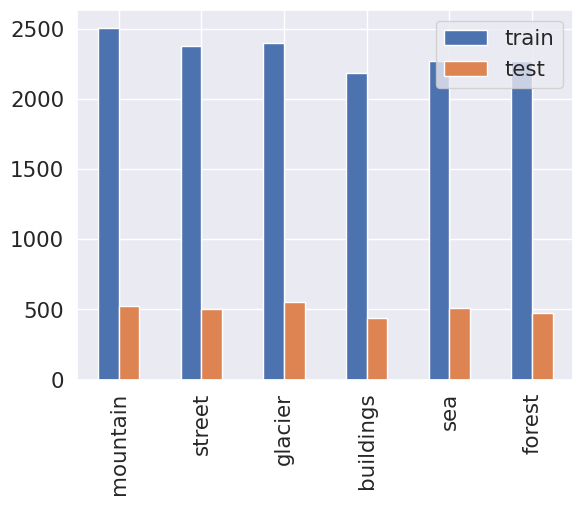

In [8]:
import pandas as pd


_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

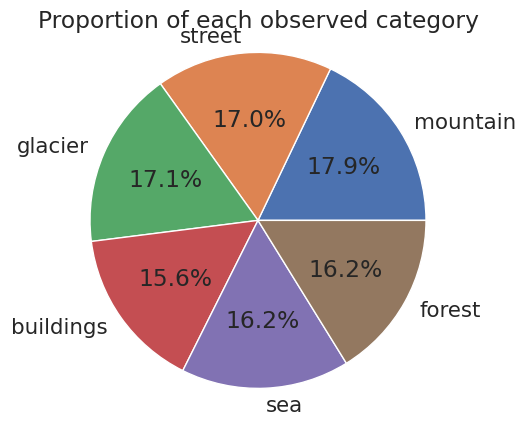

In [9]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [10]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [11]:
def display_random_image(class_names, images, labels):
    
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

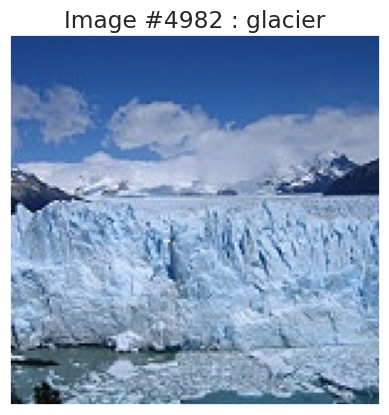

In [12]:
display_random_image(class_names, train_images, train_labels)

In [13]:
def display_examples(class_names, images, labels):
    
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

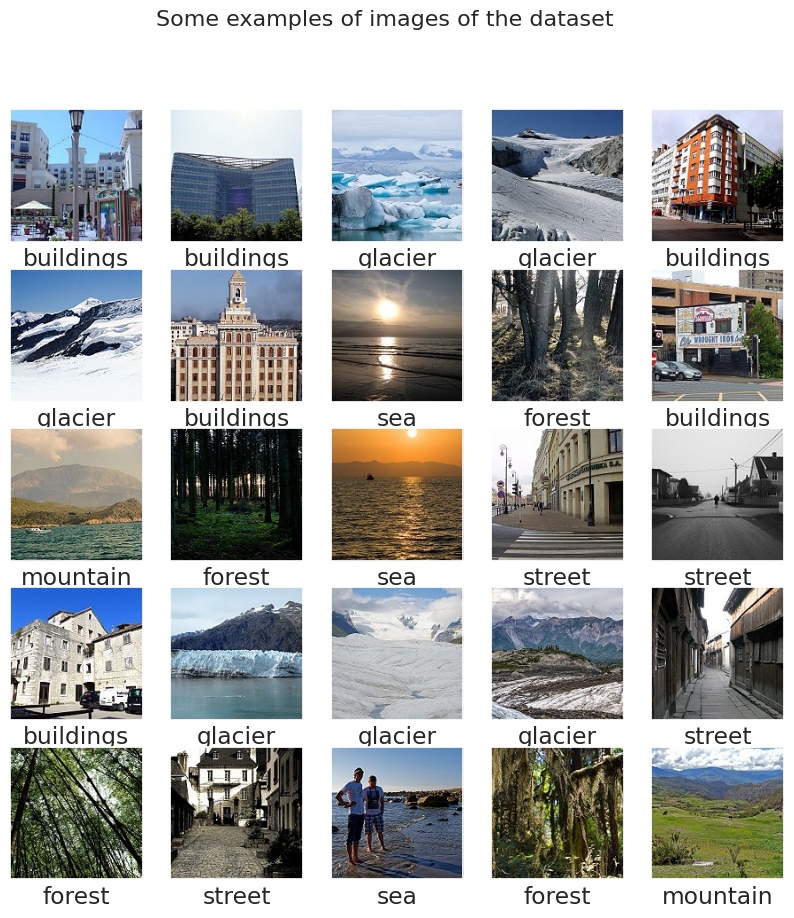

In [14]:
display_examples(class_names, train_images, train_labels)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)


Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.4376 - loss: 1.6047 - val_accuracy: 0.7157 - val_loss: 0.7789
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7434 - loss: 0.7262 - val_accuracy: 0.7631 - val_loss: 0.6705
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8043 - loss: 0.5451 - val_accuracy: 0.7895 - val_loss: 0.5894
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8638 - loss: 0.4098 - val_accuracy: 0.7862 - val_loss: 0.6074
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9043 - loss: 0.2992 - val_accuracy: 0.7645 - val_loss: 0.6881
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9276 - loss: 0.2318 - val_accuracy: 0.7848 - val_loss: 0.6648
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9576 - loss: 0.1515 - val_accuracy: 0.7652 - val_loss: 0.7560
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9735 - loss: 0.1138 - val_accuracy: 0.7642 - v

In [21]:
def plot_accuracy_loss(history):
   
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

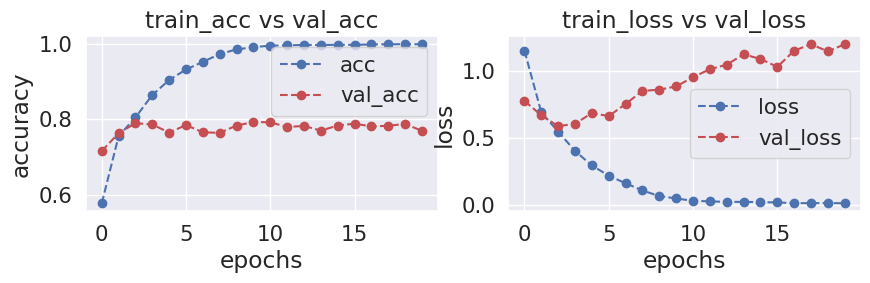

In [22]:
plot_accuracy_loss(history)


In [23]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

In [25]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step


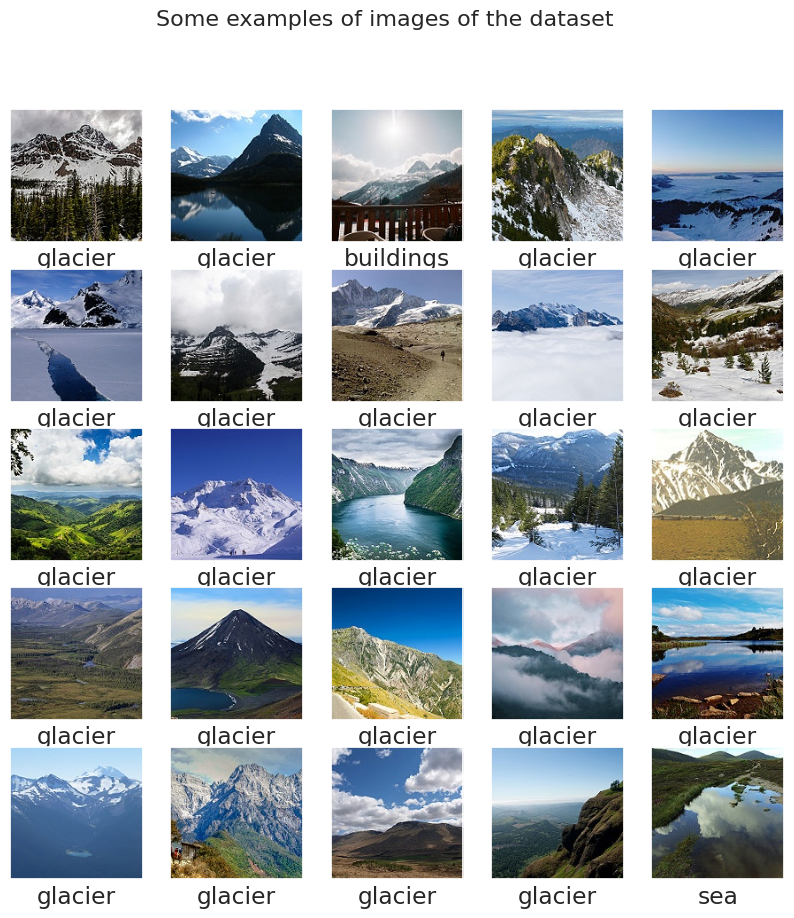

In [26]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

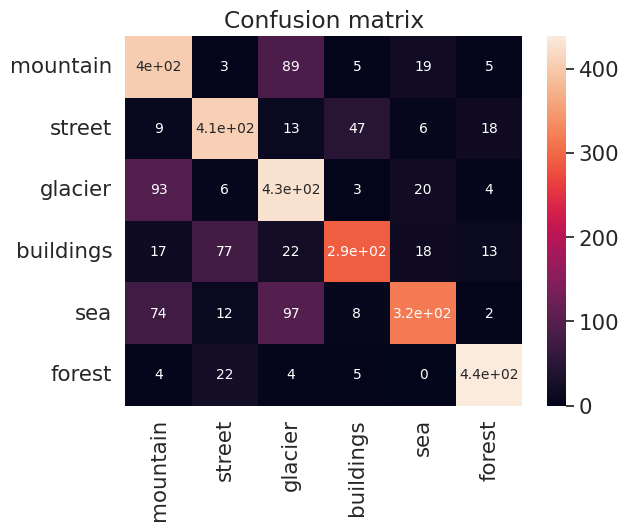

In [27]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()